In [ ]:
## CPU specs ##
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	:

In [ ]:
!cat /proc/meminfo

MemTotal:       13333556 kB
MemFree:        10530824 kB
MemAvailable:   12459492 kB
Buffers:           75956 kB
Cached:          2010204 kB
SwapCached:            0 kB
Active:           735188 kB
Inactive:        1786424 kB
Active(anon):     415112 kB
Inactive(anon):      340 kB
Active(file):     320076 kB
Inactive(file):  1786084 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               168 kB
Writeback:             0 kB
AnonPages:        435560 kB
Mapped:           222136 kB
Shmem:               964 kB
Slab:             167272 kB
SReclaimable:     126800 kB
SUnreclaim:        40472 kB
KernelStack:        3584 kB
PageTables:         5504 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6666776 kB
Committed_AS:    2536576 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:              920 kB
AnonHugePages:   

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  | Proc size: 111.7 MB
GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#############################################
## required to import custom modules in GC ##
import sys
sys.path.append('/content/drive/My Drive/PyTorchDIA - Real Image Tests')
##############################################

# grab photutils
#!pip install photutils

# other useful imports
import numpy as np
import os
import glob
from astropy.io.fits import getdata
from astropy.stats import mad_std
#from photutils import DAOStarFinder
import time
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from scipy.ndimage.interpolation import shift
from scipy.stats import norm
import PyTorchDIA_FullLikelihood_lossconv
#import PyTorchDIA_FullLikelihood_lossconv_double
#import PyTorchDIA_RobustLoss_Sinistro
import torch
%matplotlib inline

PyTorch version: 1.6.0+cu101


In [ ]:
### pyDANDIA ###
%load_ext Cython

In [ ]:
%%cython

from __future__ import division
import numpy as np
import time
cimport numpy as np
cimport cython
DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

# compile suggestion: gcc -shared -pthread -fPIC -fwrapv -O2 -Wall -fno-strict-aliasing -I/somepath/include/python2.7 -o umatrix_routine.so umatrix_routine.c

@cython.boundscheck(False) # turn off bounds-checking
@cython.wraparound(False)  # turn off negative index wrapping
@cython.nonecheck(False)  # turn off negative index wrapping

def umatrix_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(reference_image)[0]
    cdef int nj_image = np.shape(reference_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
    cdef np.ndarray u_matrix = np.zeros([n_kernel + 1, n_kernel + 1], dtype=DTYPE)

    for idx_p in range(n_kernel):
        for idx_q in range(idx_p,n_kernel):
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * reference_image[idx_i + idx_l_prime,idx_j + idx_m_prime]  * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
            u_matrix[idx_q, idx_p] = sum_acc

    for idx_p in [n_kernel]:
        for idx_q in range(n_kernel):
            sum_acc = 0.
            idx_l = kernel_size
            idx_m = kernel_size
            idx_l_prime, idx_m_prime = pandq[idx_q]
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l_prime, idx_j + idx_m_prime] * weights[idx_i, idx_j]
            u_matrix[idx_p, idx_q] = sum_acc
    
    for idx_p in range(n_kernel):
        for idx_q in [n_kernel]:
            sum_acc = 0.
            idx_l, idx_m = pandq[idx_p]
            idx_l_prime = kernel_size
            idl_m_prime = kernel_size
            for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
                for idx_j in range(kernel_size_half, nj_image-kernel_size+kernel_size_half+1):
                    sum_acc += reference_image[idx_i + idx_l, idx_j + idx_m] * weights[idx_i, idx_j] 
            u_matrix[idx_p, idx_q] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += weights[idx_i, idx_j] 
    u_matrix[n_kernel, n_kernel] = sum_acc
    
    return u_matrix

def bvector_construction(np.ndarray[DTYPE_t, ndim = 2] reference_image,np.ndarray[DTYPE_t, ndim = 2] data_image,np.ndarray[DTYPE_t, ndim = 2] weights, pandq, n_kernel_np, kernel_size_np):

    cdef int ni_image = np.shape(data_image)[0]
    cdef int nj_image = np.shape(data_image)[1]
    cdef double sum_acc = 0.
    cdef int idx_l,idx_m,idx_l_prime,idx_m_prime,idx_i,idx_j
    cdef int kernel_size = np.int(kernel_size_np)
    cdef int kernel_size_half = np.int(kernel_size_np)/2
    cdef int n_kernel = np.int(n_kernel_np)
        
    cdef np.ndarray b_vector = np.zeros([n_kernel + 1], dtype=DTYPE)
    for idx_p in range(n_kernel):
        idx_l, idx_m = pandq[idx_p]
        sum_acc = 0.
        for idx_i in range(kernel_size_half,ni_image-kernel_size+kernel_size_half+1):
            for idx_j in range(kernel_size_half,nj_image-kernel_size+kernel_size_half+1):
                   sum_acc += data_image[idx_i, idx_j] * reference_image[idx_i + idx_l , idx_j + idx_m ] * weights[idx_i, idx_j]
        b_vector[idx_p] = sum_acc

    sum_acc = 0.
    for idx_i in range(ni_image):
        for idx_j in range(nj_image):
            sum_acc += data_image[idx_i, idx_j] * weights[idx_i, idx_j]
    b_vector[n_kernel] = sum_acc

    return b_vector


## Specify all the functions required ##

def extend_image(image, kernel_size):
    image_extended = np.zeros((np.shape(image)[0] + 2 * kernel_size,
                             np.shape(image)[1] + 2 * kernel_size))
    image_extended[kernel_size:-kernel_size, kernel_size:-kernel_size] = np.array(image, float)
    
    return image_extended

# function to build the kernel, U matrix and b vector
def construct_kernel_and_matrices(kernel_size, R, I, weights):

    pandq = []
    n_kernel = kernel_size * kernel_size
    ncount = 0
    half_kernel_size = int(int(kernel_size) / 2)
    for lidx in range(kernel_size):
        for midx in range(kernel_size):
            pandq.append((lidx - half_kernel_size, midx - half_kernel_size))


    R = R.astype('float64')
    I =  I.astype('float64')
    weights = weights.astype('float64')

    start_time = time.time()
    U = umatrix_construction(R, weights, pandq, n_kernel, kernel_size)
    b = bvector_construction(R, I, weights, pandq, n_kernel, kernel_size)
    print("--- Finished U and b construction in %s seconds ---" % (time.time() - start_time))
    return U, b


# define a function for the least-squares solution
def lstsq_solution(R, I, U, b, kernel_size):
    
    lstsq_result = np.linalg.lstsq(np.array(U), np.array(b), rcond=None)
    a_vector = lstsq_result[0]
    lstsq_fit = np.dot(np.array(U), a_vector)
    resid = np.array(b) - lstsq_fit
    reduced_chisqr = np.sum(resid ** 2) / (float(kernel_size * kernel_size))
    lstsq_cov = np.dot(np.array(U).T, np.array(U)) * reduced_chisqr
    resivar = np.var(resid, ddof=0) * float(len(a_vector))
    
    # use pinv in order to stabilize calculation
    a_var = np.diag(np.linalg.pinv(lstsq_cov) * resivar)

    a_vector_err = np.sqrt(a_var)
    output_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        output_kernel = a_vector[:-1]
    else:
        output_kernel = a_vector
    output_kernel = output_kernel.reshape((kernel_size, kernel_size))

    err_kernel = np.zeros(kernel_size * kernel_size, dtype=float)
    if len(a_vector) > kernel_size * kernel_size:
        err_kernel = a_vector_err[:-1]
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))
    else:
        err_kernel = a_vector_err
        err_kernel = err_kernel.reshape((kernel_size, kernel_size))

    output_kernel_2 = np.flip(np.flip(output_kernel, 0), 1)
    err_kernel_2 = np.flip(np.flip(err_kernel, 0), 1)
    bkg_kernel = a_vector[-1]
    output_kernel_2.shape

    return output_kernel_2, bkg_kernel

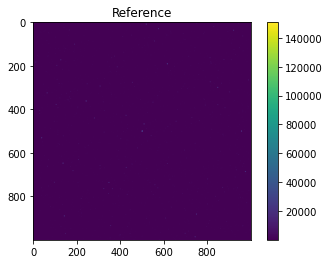

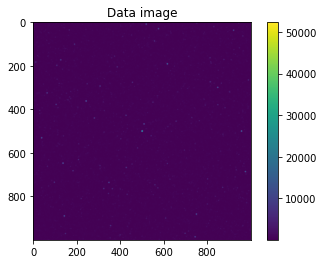

(1000, 1000) (1000, 1000)


In [ ]:
## load images, reference and master flat ##
## this can take a while in colab

## path to images
path = '/content/drive/My Drive/PyTorchDIA - Real Image Tests/Sinistro Simulations'

## reference
ref_file = os.path.join(path, 'ref_lsc_verycrowded.fits')
ref_data = getdata(ref_file, header=True)
ref = ref_data[0]

## data image
image_file = os.path.join(path, 'imag_lsc_verycrowded.fits')
image_data = getdata(image_file, header=True)
image = image_data[0]

## master flat
master_flat = np.ones(ref.shape)

## crop reference and master flat ##
#crop = 60
crop = 0
ref = ref[crop:ref.shape[0]-crop, crop:ref.shape[1]-crop]
image = image[crop:image.shape[0]-crop, crop:image.shape[1]-crop]
master_flat = master_flat[crop:master_flat.shape[0]-crop, crop:master_flat.shape[1]-crop]

plt.title('Reference')
plt.imshow(ref)
plt.colorbar()
plt.show()

plt.title('Data image')
plt.imshow(image)
plt.colorbar()
plt.show()


## ensure dtype=np.float32
ref = np.array(ref, dtype=np.float32)
image = np.array(image, dtype=np.float32)
master_flat = np.array(master_flat, dtype=np.float32)

print(ref.shape, image.shape)

Sky [ADU]: 259.41394

Kernel size: 19
--- Time to move data onto GPU: 0.002329587936401367 ---
Check dtype of weights and data
torch.float32 torch.float32 torch.float32 torch.float32
Check shapes of data and model parameters
torch.Size([1, 1, 1000, 1000]) torch.Size([1, 1, 1000, 1000]) torch.Size([1, 1, 19, 19]) torch.Size([1])
Switching to Quasi-Newton step after 3104 SD steps
1.0003770589828491 207.7650146484375
'Speedy' convergence reached!
SD steps taken: 3104
Newton steps taken: 18
--- Finished kernel and background fit in 47.34123778343201 seconds ---
Parameter containing:
tensor([207.7650], device='cuda:0', requires_grad=True)
Photometric scaling: tensor(1.0004, device='cuda:0', grad_fn=<SumBackward0>)
B_0: 207.7650146484375


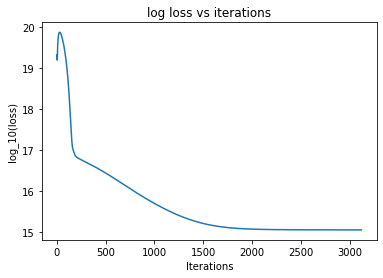

This version does not print parameter values vs iterations yet!
--- Finished in a total of 47.47581124305725 seconds ---


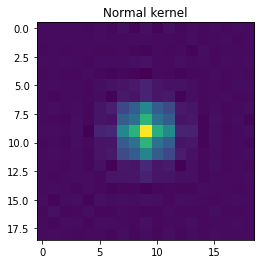

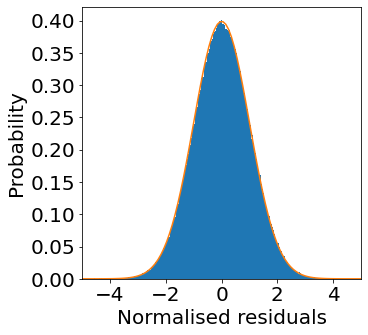

[47.47587847709656]
47.47587847709656


In [ ]:
## run this cell once to load gpu, then run again for actual test
## gpu overhead associated with first loading it will screw with the
## actual solutiontimes for the very first image

torch.backends.cudnn.enabled = True
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False


# define function to return fit quality metrics
def metrics(M, I, noise_map, kernel_size, mask):
    
    # crop image edges to exlcude convolution artefacts
    M = M[kernel_size:M.shape[0]-kernel_size, kernel_size:M.shape[1]-kernel_size]
    I = I[kernel_size:I.shape[0]-kernel_size, kernel_size:I.shape[1]-kernel_size]
    noise_map = noise_map[kernel_size:noise_map.shape[0]-kernel_size, kernel_size:noise_map.shape[1]-kernel_size]
    mask = mask[kernel_size:mask.shape[0]-kernel_size, kernel_size:mask.shape[1]-kernel_size]
    
    # calculate metrics
    #x[~np.array(mask)]
    N_data = len(I[~mask].flatten())
    MFB = 1./(N_data) * np.sum((I - M)/noise_map)
    MFV = 1./(N_data - 1) * np.sum((((I - M)/noise_map) - MFB)**2)
    return MFB, MFV

# cutout stamp around position of selected stars
def make_stamp(image, pos, stamp_size):
    rad = np.int(stamp_size/2)
    x_centroid, y_centroid = pos[1], pos[0]
    x_max, x_min = x_centroid + rad, x_centroid - rad
    y_max, y_min = y_centroid + rad, y_centroid - rad
    stamp = image[x_min:x_max+1, y_min:y_max+1]
    return stamp

# cutout stamp around position of selected stars
def make_fit_cutout(image_stamp, c_size):
    centre = np.int(image_stamp.shape[0]/2)
    radius = np.int((c_size/2))
    cutout = image_stamp[centre - radius:centre + radius + 1, centre - radius:centre + radius + 1]
    return cutout

## sky subtract reference
print('Sky [ADU]:', np.median(image))
ref -= np.median(ref)


start_time = time.time()

SD_steps = 25000
#ks = 19

kernel_sizes = [5, 7, 9, 11, 13, 15, 17, 19, 21, 25, 27, 29, 31, 33, 49]
#kernel_sizes = [27, 29, 31]
kernel_sizes = [19]
times = []


#for i in range(0, 5):
for ks in kernel_sizes:
  print('\nKernel size:', ks)
  
  for i in range(0, 1):
    start = time.time()
    
    kernel, B0, failed = PyTorchDIA_FullLikelihood_lossconv.DIA(ref,
                                image,
                                master_flat, # flatfield
                                read_noise = 0.,
                                ks = ks,
                                lr_kernel = 1e-3,
                                lr_B = 1e2,
                                SD_steps = SD_steps,
                                Newton_tol = 1e-6,
                                poly_degree=0,
                                fast=True,
                                tol = 1e-9,
                                max_iterations = SD_steps + 25,
                                fisher=False,
                                show_convergence_plots=True)
    '''
    kernel, B0, failed = PyTorchDIA_FullLikelihood_lossconv_double.DIA(ref,
                                image,
                                master_flat, # flatfield
                                read_noise = 0.,
                                ks = ks,
                                lr_kernel = 1e-3,
                                lr_B = 1e2,
                                SD_steps = SD_steps,
                                Newton_tol = 1e-6,
                                poly_degree=0,
                                fast=True,
                                tol = 1e-9,
                                max_iterations = SD_steps + 25,
                                fisher=False,
                                show_convergence_plots=True)
    '''
    times.append(time.time() - start)

# inspect kernel
plt.title('Normal kernel')
plt.imshow(kernel)
plt.show()


ext_ref = extend_image(ref, ks)
ext_M = convolve2d(ext_ref, kernel, mode='same') + B0
M = ext_M[ks:ext_M.shape[0]-ks, ks:ext_M.shape[1]-ks]

# noise model
G = 1
sigma0 = 5
NM = np.sqrt((sigma0**2/master_flat**2) + (M/G*master_flat))

# difference image and normalised residuals
D = M - image
residuals = D/NM

# inspect plots of residuals
plt.figure(figsize=(5,5))
plt.hist(residuals.flatten(), bins='auto', density=True)
x = np.linspace(-5, 5, 100)
plt.plot(x, norm.pdf(x, 0, 1))
plt.xlim(-5, 5)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Normalised residuals', fontsize=20)
plt.ylabel('Probability', fontsize=20)
#plt.savefig(os.path.join(path, 'NormalisedResids.png'), bbox_inches='tight', overwrite=True)
plt.show()

print(times)
print(np.median(times))

In [ ]:
print(times)

[11.187109470367432, 4.961020469665527, 16.510274171829224, 31.532198429107666, 53.60998868942261, 22.30297017097473, 29.5717134475708, 38.72928810119629, 46.00723052024841, 64.46026229858398, 73.99071025848389, 83.67208313941956, 94.38430142402649, 109.54260420799255]


Text(0, 0.5, 'Image SNR')

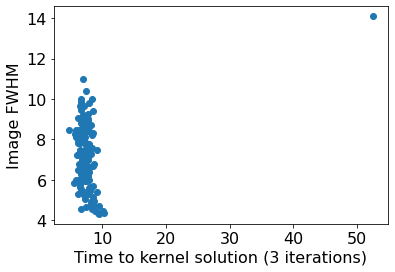

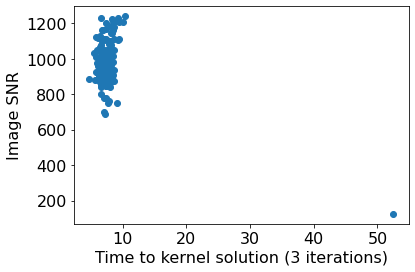

In [ ]:
## plots
fontsize = 16

plt.figure()
plt.scatter(total_times, image_FWHMs)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Time to kernel solution (3 iterations)', fontsize=fontsize)
plt.ylabel('Image FWHM', fontsize=fontsize)

plt.figure()
plt.scatter(total_times, image_SNRs)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.xlabel('Time to kernel solution (3 iterations)', fontsize=fontsize)
plt.ylabel('Image SNR', fontsize=fontsize)

In [ ]:
# other metrics info
print(len(total_times), len(image_FWHMs), len(image_SNRs))
print('Median solution time:', np.median(total_times))
print('Median FWHM:', np.median(image_FWHMs))
print('Median SNR:', np.median(image_SNRs))


158 158 158
Median solution time: 2.966955542564392
Median FWHM: 7.478626311636683
Median SNR: 261.7448


In [ ]:
out = np.vstack((total_times, image_FWHMs, image_SNRs)).T
print(out.shape)
np.savetxt(os.path.join(path,'performance_data_112x112_25x25_no_read_noise.txt'), out)

(158, 3)


In [ ]:
    '''
    ### pyDANDIA ###
    pyDANDIA_start = time.time()

    ss = 19

    mask = np.zeros(image.shape)


    for iters in range(0, 3):
        
        # pixel uncertanties
        sigma0 = 2.55 # read noise
        N = N_images[i] # number of images
        gain_CCD = 25.8 # CCD gain
        gain_EM = 300. # EM gain
        G = gain_CCD / gain_EM # Total gain
        excess_noise_factor = 2 # EMCCD fudge factor
        if iters == 0:
            shot_noise = image/(G*flat)
        else:
            shot_noise = model/(G*flat)   
        read_noise = N*sigma0**2 / flat**2
        var_model = excess_noise_factor*(shot_noise + read_noise)
        pixel_uncertanties = np.sqrt(var_model) 
        
        # Noise Model
        weights = 1./var_model
        # mask outliers
        weights[np.where(mask == 1)] = 1e-198
        print('\nMasked pixels (pyDANDIA):', np.sum(mask))
        print('\npyDANDIA solution, iter %d' % iters)
        ext_ref = extend_image(ref, ss)
        ext_imag = extend_image(image, ss)
        ext_weights = extend_image(weights, ss)

        U, b = construct_kernel_and_matrices(ss, ext_ref, ext_imag, ext_weights)
        kernel, B0 = lstsq_solution(ext_ref, ext_imag, U, b, ss)
        print('P:', np.sum(kernel))
        print('B0:', B0)
        start_conv2d = time.time()
        model = convolve2d(ref, kernel, mode='same') + B0
        print('Conv2d time:', time.time() - start_conv2d)
        print('weights shape:', weights.shape)
        print('image shape:', image.shape)
        print('model:', model.shape)
        norm_resids = np.sqrt(weights)*(image - model)
        mask[np.where(np.abs(norm_resids)>1e99)] = 1
        
        print('Sum abs(norm_resids):', np.sum(np.abs(norm_resids)))
        '''
        '''
        plt.figure(figsize=(5,5))
        plt.hist(norm_resids.flatten(), bins='auto', density=True)
        #x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
        x = np.linspace(-5, 5, 100)
        plt.plot(x, norm.pdf(x, 0, 1))
        plt.xlim(-5, 5)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        plt.xlabel('Normalised residuals', fontsize=20)
        plt.ylabel('Probability', fontsize=20)
        #plt.savefig(os.path.join(path, 'NormalisedResids.png'), bbox_inches='tight', overwrite=True)
        plt.show()
        '''
        '''
    # solution time
    #times_to_kernel_solution.append(solve_times)
    total_time = time.time() - pyDANDIA_start
    total_times.append(total_time)
    print('pyDANDIA time:', total_time)

    '''